<a href="https://colab.research.google.com/github/Sam-Huin/atom/blob/master/Capstone_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install scrapy
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.9MB/s 


LIBRARY IMPORTS

In [3]:
# pandas
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split

#auto_arima
from pmdarima.arima import auto_arima

# keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, LeakyReLU
from keras import optimizers

# visual
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# others
import numpy as np
import requests
import time
import io
#from bs4 import BeautifulSoup
#from scrapy.selector import Selector
#from scrapy.http import HtmlResponse
from google.colab import files

Using TensorFlow backend.


IMPORTING DATASETS

In [0]:
#url = 'https://raw.git.generalassemb.ly/samuel-huin/classes/master/A%20CapstonE/datasets/bitcoin_3hrs?token=AABctR3oHvC84GCBK0-gRJOSlOdZxgPNks5eEOY5wA%3D%3D'
#pd_btc = pd.read_csv(url)    #getting dataset from GitHub URL
#pd_btc = pd.read_csv('./datasets/bitcoin_3hrs')    #getting csv from local machine

In [4]:
#import files to Google Colab
uploaded = files.upload()

Saving bitcoin_3hrs.csv to bitcoin_3hrs.csv


In [11]:
# Dataset is now stored in a Pandas Dataframe
pd_btc = pd.read_csv(io.BytesIO(uploaded['bitcoin_3hrs.csv']))
pd_btc.shape

(8101, 6)

In [0]:
# set index to DateTime columns in dataset and changing the datatypes
pd_btc['Date_Time'] = pd.to_datetime(pd_btc['Date_Time'])
pd_btc.set_index('Date_Time', inplace=True)
pd_btc.sort_index(inplace=True)

In [13]:
pd_btc.dtypes

Open      float64
Close     float64
High      float64
Low       float64
Volume    float64
dtype: object

In [14]:
pd_btc.shape

(8101, 5)

In [15]:
pd_btc.tail(10)

Open        Close    High          Low  \
Date_Time                                                            
2019-10-09 09:00:00  8223.400000  8209.300000  8274.9  8193.269653   
2019-10-09 12:00:00  8209.102673  8486.000000  8500.0  8188.000000   
2019-10-09 15:00:00  8485.000000  8666.500000  8697.0  8475.600000   
2019-10-09 18:00:00  8664.002481  8612.500000  8719.2  8565.100000   
2019-10-09 21:00:00  8612.527806  8607.500000  8651.0  8550.000000   
2019-10-10 00:00:00  8607.400000  8579.100000  8634.0  8553.400000   
2019-10-10 03:00:00  8579.100000  8584.127009  8615.9  8570.000000   
2019-10-10 06:00:00  8584.000000  8592.192830  8683.9  8569.918081   
2019-10-10 09:00:00  8592.200000  8567.200000  8592.2  8523.200000   
2019-10-10 12:00:00  8567.176351  8532.900000  8567.2  8472.000000   

                          Volume  
Date_Time                         
2019-10-09 09:00:00   710.193748  
2019-10-09 12:00:00  2666.835257  
2019-10-09 15:00:00  2981.992178  
2019-10-09 18:00:00   811.600965  
2019-10-09 21:00:00   550.155942  
2019-10-10 00:00:00   518.767511  
2019-10-10 03:00:00   324.916468  
2019-10-10 06:00:00   866.301811  
2019-10-10 09:00:00   578.696478  
2019-10-10 12:00:00   834.996094

Calculate Trading True Range Value

In [0]:
#Calculate the price values for each day

pd_btc['High_Low'] = pd_btc['High'] - pd_btc['Low']
pd_btc['High_Open'] = pd_btc['High'] - pd_btc['Open']
pd_btc['Low_Open'] = pd_btc['Open'] - pd_btc['Low']

In [0]:
#Calculating the True Range of prices for each day

def count_tr(df):
    list_num = []
    for i in range(len(df)):
        if df.iloc[i]['High'] > df.iloc[i]['Open']:
          list_num.append(df.iloc[i]['High_Open'] + df.iloc[i]['Low_Open'])                           
        else:
          list_num.append(df.iloc[i]['High_Low'])
    return list_num

In [18]:
pd_btc['TR'] = count_tr(pd_btc)
pd_btc.head(10)

Open    Close     High      Low       Volume  \
Date_Time                                                              
2017-01-01 00:00:00   966.61   965.00   967.79   965.00   226.067256   
2017-01-01 03:00:00   965.01   964.88   965.20   961.26   228.311999   
2017-01-01 06:00:00   963.90   965.46   967.45   962.60   282.771187   
2017-01-01 09:00:00   965.41   978.16   978.89   965.37  1806.444917   
2017-01-01 12:00:00   977.11   978.45   978.59   970.85   490.728218   
2017-01-01 15:00:00   978.50   994.31   999.00   976.24  6258.074560   
2017-01-01 18:00:00   993.75  1004.00  1005.00   993.68  2339.555718   
2017-01-01 21:00:00  1004.80   998.99  1006.50   991.50  1809.195121   
2017-01-02 00:00:00   999.00  1011.50  1011.50   997.30  1082.202504   
2017-01-02 03:00:00  1011.50  1011.40  1018.00  1008.90  1395.572794   

                     High_Low  High_Open  Low_Open     TR  
Date_Time                                                  
2017-01-01 00:00:00      2.79       1.18      1.61   2.79  
2017-01-01 03:00:00      3.94       0.19      3.75   3.94  
2017-01-01 06:00:00      4.85       3.55      1.30   4.85  
2017-01-01 09:00:00     13.52      13.48      0.04  13.52  
2017-01-01 12:00:00      7.74       1.48      6.26   7.74  
2017-01-01 15:00:00     22.76      20.50      2.26  22.76  
2017-01-01 18:00:00     11.32      11.25      0.07  11.32  
2017-01-01 21:00:00     15.00       1.70     13.30  15.00  
2017-01-02 00:00:00     14.20      12.50      1.70  14.20  
2017-01-02 03:00:00      9.10       6.50      2.60   9.10

TRAIN-TEST SPLIT

In [0]:
def train_test_split(df, test_size=None, shuffle=False):
  split = len(df) - int(len(df)*test_size)
  train_set = df[:split]
  test_set = df[split-1:]
  return train_set, test_set

In [20]:
train_set, test_set = train_test_split(pd_btc, test_size=0.2, shuffle=False)
print(pd_btc.shape)
print(train_set.shape)
print(test_set.shape)

(8101, 9)
(6481, 9)
(1621, 9)


In [21]:
#train_set start and end DateTime
print (train_set.index[0])
print (train_set.index[-1])

2017-01-01 00:00:00
2019-03-22 00:00:00


In [22]:
train_set.tail()

Open   Close    High         Low       Volume  \
Date_Time                                                                  
2019-03-21 12:00:00  4124.92637  4012.0  4146.9  4004.00000  3691.323418   
2019-03-21 15:00:00  4011.90000  4036.7  4047.0  4008.80482  2397.208284   
2019-03-21 18:00:00  4036.80000  4043.5  4044.8  4032.85780   637.223609   
2019-03-21 21:00:00  4043.50000  4044.8  4056.3  4043.40000   602.607913   
2019-03-22 00:00:00  4044.90000  4049.3  4052.9  4041.80000   419.954980   

                      High_Low  High_Open   Low_Open         TR  
Date_Time                                                        
2019-03-21 12:00:00  142.90000   21.97363  120.92637  142.90000  
2019-03-21 15:00:00   38.19518   35.10000    3.09518   38.19518  
2019-03-21 18:00:00   11.94220    8.00000    3.94220   11.94220  
2019-03-21 21:00:00   12.90000   12.80000    0.10000   12.90000  
2019-03-22 00:00:00   11.10000    8.00000    3.10000   11.10000

In [23]:
#test_set start and end DateTime
print (test_set.index[0])
print (test_set.index[-1])

2019-03-22 00:00:00
2019-10-10 12:00:00


In [24]:
test_set.head()

Open   Close         High     Low      Volume  \
Date_Time                                                                   
2019-03-22 00:00:00  4044.900000  4049.3  4052.900000  4041.8  419.954980   
2019-03-22 03:00:00  4049.300000  4043.2  4049.400000  4042.6  277.957053   
2019-03-22 06:00:00  4043.146325  4046.9  4050.500000  4034.9  956.300570   
2019-03-22 09:00:00  4046.900000  4047.8  4050.289582  4044.0  455.175934   
2019-03-22 12:00:00  4047.800000  4060.3  4070.600000  4045.8  821.635108   

                      High_Low  High_Open  Low_Open         TR  
Date_Time                                                       
2019-03-22 00:00:00  11.100000   8.000000  3.100000  11.100000  
2019-03-22 03:00:00   6.800000   0.100000  6.700000   6.800000  
2019-03-22 06:00:00  15.600000   7.353675  8.246325  15.600000  
2019-03-22 09:00:00   6.289582   3.389582  2.900000   6.289582  
2019-03-22 12:00:00  24.800000  22.800000  2.000000  24.800000

In [25]:
test_set.tail()

Open        Close    High          Low  \
Date_Time                                                            
2019-10-10 00:00:00  8607.400000  8579.100000  8634.0  8553.400000   
2019-10-10 03:00:00  8579.100000  8584.127009  8615.9  8570.000000   
2019-10-10 06:00:00  8584.000000  8592.192830  8683.9  8569.918081   
2019-10-10 09:00:00  8592.200000  8567.200000  8592.2  8523.200000   
2019-10-10 12:00:00  8567.176351  8532.900000  8567.2  8472.000000   

                         Volume    High_Low  High_Open   Low_Open          TR  
Date_Time                                                                      
2019-10-10 00:00:00  518.767511   80.600000  26.600000  54.000000   80.600000  
2019-10-10 03:00:00  324.916468   45.900000  36.800000   9.100000   45.900000  
2019-10-10 06:00:00  866.301811  113.981918  99.900000  14.081919  113.981918  
2019-10-10 09:00:00  578.696478   69.000000   0.000000  69.000000   69.000000  
2019-10-10 12:00:00  834.996094   95.200000   0.023649  95.176351   95.200000

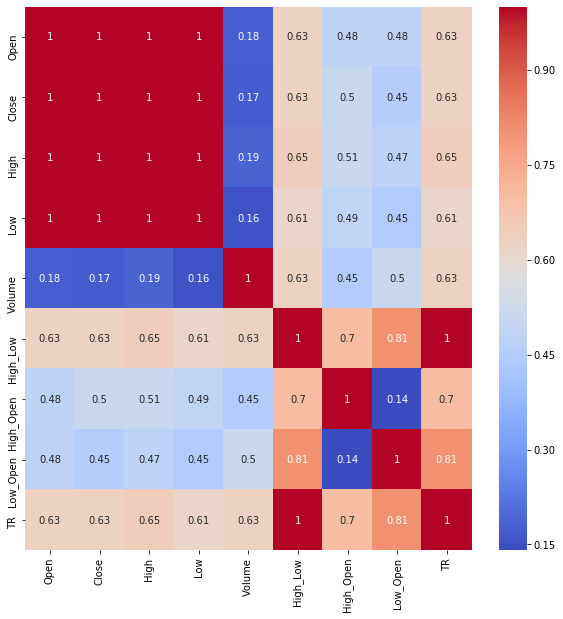

In [26]:
fig = plt.figure(figsize=(10,10))

sns.heatmap(pd_btc.corr(), annot=True, cmap='coolwarm')

GRAPHS PLOTTING

In [0]:
#plotting of prices attributes - Open, Close, High, Low

def plot_graph(line1=None, line2=None, line3=None, line4=None, title=None, lw=2):
    trace1 = go.Scatter(
      x = line1.index,
      y = line1,
      mode = 'lines',
      name = line1.name)

    trace2 = go.Scatter(
      x = line2.index,
      y = line2,
      mode = 'lines',
      name = line2.name)

    trace3 = go.Scatter(
      x = line3.index,
      y = line3,
      mode = 'lines',
      name = line3.name)

    trace4 = go.Scatter(
      x = line4.index,
      y = line4,
      mode = 'lines',
      name = line4.name)

    layout = go.Layout(
      title = title,
      xaxis = {'title' : "Date"},
      yaxis = {'title' : "Price (USD)"})

    fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
    fig.show()

#plt.figure(figsize=(20, 10))
#plt.plot(pd_btc['Open'])
#plt.plot(pd_btc['Close'])
#plt.plot(pd_btc['High'])
#plt.plot(pd_btc['Low'])
#plt.title('Bitcoin Price Attributes')
#plt.ylabel('Price (USD)')
#plt.xlabel('Date')
#plt.legend(['Open','Close','High','Low'], loc='upper left')
#plt.show()

In [0]:
#plotting of train test dataset

def plot_train_test(line1, line2, title=None, lw=2, color=None): 
    trace1 = go.Scatter(
        x = line1.index,
        y = line1,
        mode = 'lines',
        name = 'train set ' + line1.name,
        line = dict(color = color)
    )
    trace2 = go.Scatter(
        x = line2.index,
        y = line2,
        mode = 'lines',
        name = 'test set ' + line2.name,
        line = dict(color = 'orange')
    )
    layout = go.Layout(
        title = title,
        xaxis = {'title' : "Date"},
    )
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()
    
#fig, ax = plt.subplots(1, figsize=(20, 10))
#ax.xaxis_date()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
#ax.plot(line1, label=label1, linewidth=lw)
#ax.plot(line2, label=label2, linewidth=lw)
#ax.set_ylabel('USD($)', fontsize=14)
#ax.set_title(title, fontsize=16)
#ax.legend(loc='upper left', fontsize=16);

In [0]:
def plot_graph_2(line1, line2, line3, line4, label1, label2, label3, label4, title, lw=2):
    fig, ax1 = plt.subplots(1, figsize=(20, 10))
    #ax.xaxis_date()
    #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.plot(line1, label=label1, linewidth=lw, color='blue')
    ax1.plot(line2, label=label2, linewidth=lw, color='orange')
    ax1.set_ylabel('USD($)', fontsize=14, color='blue')
    ax1.set_title(title, fontsize=16)
    
    ax2 = ax1.twinx()
    ax2.plot(line3, label=label3, linewidth=lw, color='green')
    ax2.plot(line4, label=label4, linewidth=lw, color='orange')
    ax2.set_ylabel('Volume', fontsize=14, color='green')
   
    ax1.legend(loc='upper left', fontsize=16);
    ax2.legend(loc='upper right', fontsize=16);

In [30]:
plot_graph(pd_btc['Open'], pd_btc['Close'], pd_btc['High'], pd_btc['Low'], 'BitCoin Prices')

In [31]:
fig = go.Figure(data=[go.Candlestick(x=pd_btc.index,
              open = pd_btc['Open'],
              close = pd_btc['Close'],
              high = pd_btc['High'],
              low = pd_btc['Low'])
                     ])

fig.show()

In [32]:
#BitCoin 'OPEN PRICE'

plot_train_test(train_set['Open'], test_set['Open'], title='OPEN PRICE', color='light blue')

In [33]:
#BitCoin 'CLOSE PRICE'

plot_train_test(train_set['Close'], test_set['Close'], title='CLOSE PRICE', color='red')

In [34]:
#BitCoin 'HIGH PRICE'

plot_train_test(train_set['High'], test_set['High'], title='HIGH PRICE', color='aqua')

In [35]:
#BitCoin 'LOW PRICE'

plot_train_test(train_set['Low'], test_set['Low'], title='LOW PRICE', color='mediumpurple')

In [36]:
#plotting of Bitcoin volume

trace = go.Scatter(
    x = pd_btc.index,
    y = pd_btc['Volume'],
    mode = 'lines',
    name = 'Volume',
    line = dict(color = 'hotpink'))

layout = go.Layout(
    title = 'BitCoin Volume',
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Volume"})

fig = go.Figure(data=[trace], layout=layout)
fig.show()

#plt.figure(figsize=(20, 10))
#plt.plot(pd_btc['Volume'])
#plt.title('Bitcoin Volume')
#plt.ylabel('Volume')
#plt.xlabel('Date')
#plt.show()

In [37]:
plot_train_test(train_set['Volume'], test_set['Volume'], title='Volume', color='hotpink')

In [38]:
plot_train_test(train_set['TR'], test_set['TR'], title='TR')

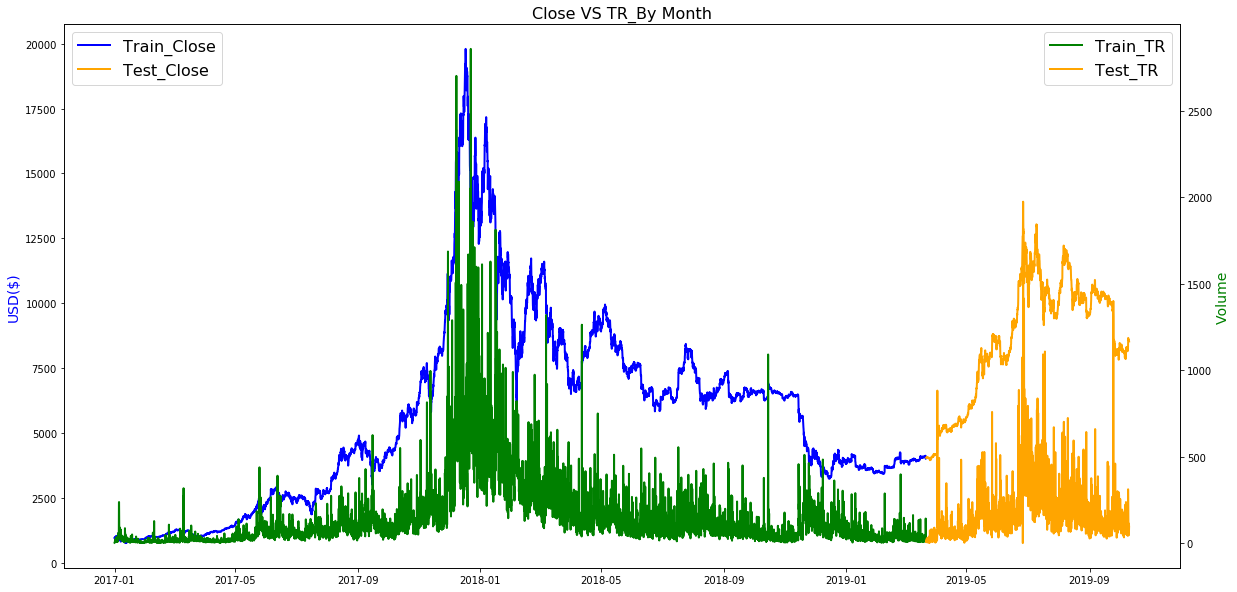

In [39]:
plot_graph_2(train_set['Close'],test_set['Close'],train_set['TR'],test_set['TR'],'Train_Close','Test_Close','Train_TR','Test_TR',title='Close VS TR_By Month')

MODELLING - LSTM NN

In [0]:
features = [i for i in pd_btc.columns if i != 'Close']
target = ['Close']

In [0]:
np.random.seed(42)
window_len = 5

In [0]:
#normalizing to change the values of numeric columns in the dataset to a common scale
def normalise_zero_base(df):
    return df / df.iloc[0] - 1
  
def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min()) 

In [0]:
def extract_window_data(df, window_len=5, zero_base=False):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        else:
            tmp = normalise_min_max(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [0]:
#prepare data to be enter into the neural network
def prepare_data(df,window_len=5,zero_base=False,test_size=0.2):
  train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
  X_train = extract_window_data(train_data[features], window_len, zero_base=False)
  X_test = extract_window_data(test_data[features], window_len, zero_base=False)
  y_train = train_data[target][window_len:].values
  y_test = test_data[target][window_len:].values
  if zero_base:
    y_train = y_train / train_data[target][:-window_len].values - 1
    y_test = y_test / test_data[target][:-window_len].values - 1
  else:
    y_train = normalise_min_max(y_train)
    y_test = normalise_min_max(y_test)

  return train_data, test_data, X_train, X_test, y_train, y_test

In [0]:
def build_lstm_model(input_data, output_size, dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2]), activation='relu'))
  model.add(LSTM(16, return_sequences=True, activation='relu'))
  model.add(LSTM(8, activation="relu"))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(LeakyReLU(alpha=0.2))
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [0]:
train, test, X_train, X_test, y_train, y_test = prepare_data(pd_btc)

In [47]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(X_test)))

False
False


In [0]:
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

In [0]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(X_test)))

False
False


In [48]:
model = build_lstm_model(input_data=X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, shuffle=True, validation_data=(X_test,
                    y_test))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6476 samples, validate on 1616 samples
Epoch 1/30





6476/6476 [==============================] - 5s 759us/step - loss: 0.0440 - val_loss: 0.1202
Epoch 2/30
6476/6476 [==============================] - 3s 450us/step - loss: 0.0371 - val_loss: 0.1305
Epoch 3/30
6476/6476 [==============================] - 3s 444us/step - loss: 0.0364 - val_loss: 0.1253
Epoch 4/30
6476/6476 [==============================] - 3s 459us/step - loss: 0.0358 - val_loss: 0.1233
Epoch 5/30
6476/6476 [==============================] - 3s 454us/step - loss: 0.0353 - val_loss: 0.1153
Epoch 6/30
6476/6476 [==============================] - 3s 459us/step - loss: 0.0354 - val_loss: 0.1245
Epoch 7/30
6476/6476 [==============================] - 3s 473us/step - loss: 0.0354 - val_loss: 0.1254
Ep

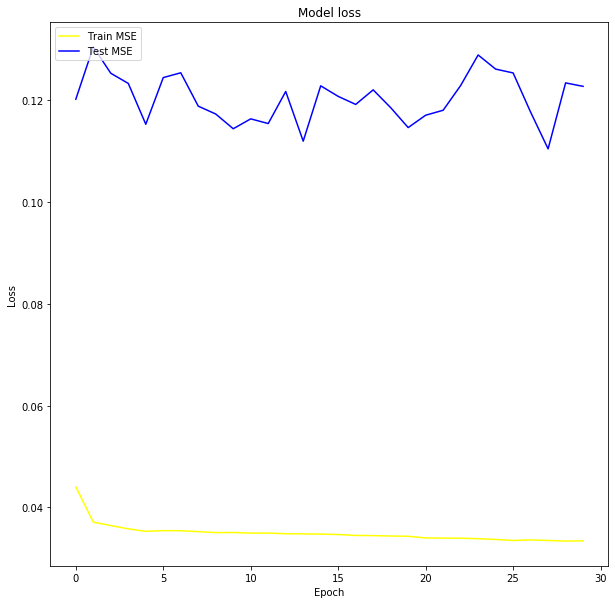

In [49]:
# Visualize the training data

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], color='yellow')
plt.plot(history.history['val_loss'], color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train MSE', 'Test MSE'], loc='upper left')

In [0]:
targets = test['Close'][window_len:]
preds = model.predict(X_test).squeeze()
preds = test['Close'].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds, name='Prediction')

In [51]:
trace1 = go.Scatter(
      x = targets.index,
      y = targets,
      mode = 'lines',
      name = 'Close'
    )
trace2 = go.Scatter(
      x = preds.index,
      y = preds,
      mode = 'lines',
      name = preds.name,
    )
layout = go.Layout(
        title = 'Actual vs Predicted',
        xaxis = {'title' : "Date"},
    )
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [52]:
mse = mean_squared_error(preds, y_test)
print ('mse = ' + str(mse))
mae = mean_absolute_error(preds, y_test)
print ('mae = ' + str(mae))

mse = 123632141.86559671
mae = 10722.006852316395


MODELLING - Keras TimeseriesGenerator

In [0]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
close_data = pd_btc['Close'].values
close_data = close_data.reshape((-1,1))

In [66]:
close_train, close_test = train_test_split(close_data, test_size=0.2, shuffle=False)
print(close_data.shape)
print(close_train.shape)
print(close_test.shape)

(8101, 1)
(6481, 1)
(1621, 1)


In [67]:
date_train, date_test = train_test_split(pd_btc.index, test_size=0.2, shuffle=False)
print(pd_btc.index.shape)
print(date_train.shape)
print(date_test.shape)

(8101,)
(6481,)
(1621,)


In [0]:
look_back = 16

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=32)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [69]:
model_future = Sequential()
model_future.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(look_back,1)))
model_future.add(LSTM(16, return_sequences=True, activation='relu'))
model_future.add(LSTM(8, activation='relu'))
model_future.add(Dense(1))
model_future.add(LeakyReLU(alpha=0.2))
model_future.compile(optimizer='adam', loss='mse')

num_epochs = 30
hist = model_future.fit_generator(train_generator, epochs=num_epochs, verbose=1, validation_data=(test_generator))

Epoch 1/30
203/203 [==============================] - 16s 80ms/step - loss: 8445938.3913 - val_loss: 326859.6788
Epoch 2/30
203/203 [==============================] - 13s 66ms/step - loss: 200949.1184 - val_loss: 319813.6707
Epoch 3/30
203/203 [==============================] - 13s 65ms/step - loss: 216442.2516 - val_loss: 163458.1329
Epoch 4/30
203/203 [==============================] - 14s 67ms/step - loss: 194838.8109 - val_loss: 157104.7499
Epoch 5/30
203/203 [==============================] - 13s 65ms/step - loss: 193799.8065 - val_loss: 180073.5760
Epoch 6/30
203/203 [==============================] - 13s 65ms/step - loss: 247050.2898 - val_loss: 306355.6007
Epoch 7/30
203/203 [==============================] - 13s 65ms/step - loss: 216064.1780 - val_loss: 275214.3321
Epoch 8/30
203/203 [==============================] - 13s 66ms/step - loss: 201578.4134 - val_loss: 221774.4256
Epoch 9/30
203/203 [==============================] - 14s 67ms/step - loss: 211591.7689 - val_loss: 188

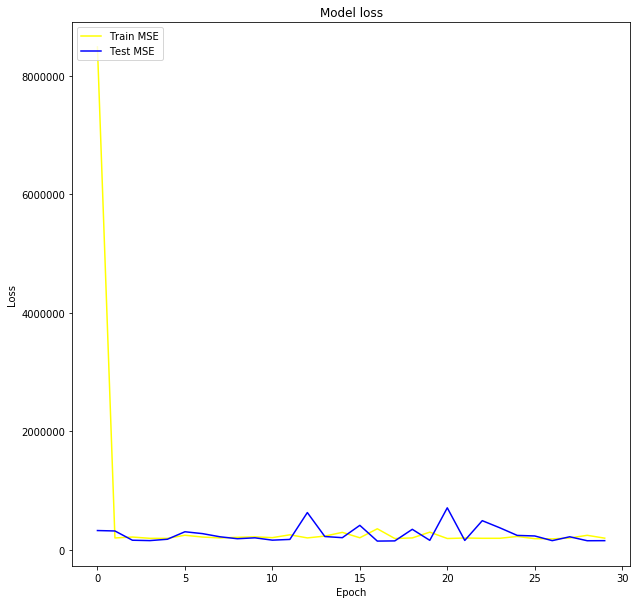

In [70]:
# Visualize the training data

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'], color='yellow')
plt.plot(hist.history['val_loss'], color='blue')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train MSE', 'Test MSE'], loc='upper left')

In [71]:
prediction = model_future.predict_generator(test_generator)


close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Train Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Test Data'
)
trace3 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "BitCoin Prices",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close Price"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()


In [72]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Test Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "BitCoin - Actual Vs Predicted",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close Price"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [74]:
mse = mean_squared_error(prediction, close_test[:-16])
print ('mse = ' + str(mse))
mae = mean_absolute_error(prediction, close_test[:-16])
print ('mae = ' + str(mae))

mse = 49604.61357735
mae = 147.2755283050767


Comparing Real time value with unseen data prediction

In [75]:
uploaded = files.upload()

Saving bitcoin_result_3h.csv to bitcoin_result_3h.csv


In [76]:
pd_result = pd.read_csv(io.BytesIO(uploaded['bitcoin_result_3h.csv']))
pd_result.shape

(801, 6)

In [0]:
pd_result['Date_Time'] = pd.to_datetime(pd_result['Date_Time'])
pd_result.set_index('Date_Time', inplace=True)
pd_result.sort_index(inplace=True)

In [82]:
pd_result.iloc[36:53]

Open        Close         High          Low  \
Date_Time                                                                 
2019-10-10 12:00:00  8567.176351  8532.900000  8567.200000  8472.000000   
2019-10-10 15:00:00  8532.700000  8534.600000  8606.700000  8520.000000   
2019-10-10 18:00:00  8534.600000  8586.800000  8621.200000  8519.100000   
2019-10-10 21:00:00  8588.100000  8596.000000  8630.700000  8558.924456   
2019-10-11 00:00:00  8596.000000  8561.024615  8608.900000  8520.600000   
2019-10-11 03:00:00  8561.000000  8459.000000  8815.300000  8385.000000   
2019-10-11 06:00:00  8459.960448  8386.000000  8465.391528  8317.000000   
2019-10-11 09:00:00  8386.000000  8330.000000  8411.300000  8302.800000   
2019-10-11 12:00:00  8330.000000  8339.726350  8379.200000  8302.000000   
2019-10-11 15:00:00  8338.900000  8361.200000  8385.000000  8311.384670   
2019-10-11 18:00:00  8360.100000  8357.000000  8385.000000  8311.800000   
2019-10-11 21:00:00  8356.100000  8278.200000  8359.400000  8253.000000   
2019-10-12 00:00:00  8278.400000  8324.400000  8353.200000  8270.500000   
2019-10-12 03:00:00  8330.200000  8363.000000  8380.000000  8314.700000   
2019-10-12 06:00:00  8363.000000  8371.700000  8380.000000  8353.500000   
2019-10-12 09:00:00  8371.700000  8341.700000  8394.000000  8322.000000   
2019-10-12 12:00:00  8341.683166  8415.800000  8423.700000  8332.100000   

                          Volume  
Date_Time                         
2019-10-10 12:00:00   834.996094  
2019-10-10 15:00:00   345.880166  
2019-10-10 18:00:00   603.958110  
2019-10-10 21:00:00   246.405935  
2019-10-11 00:00:00   171.293577  
2019-10-11 03:00:00  2551.682681  
2019-10-11 06:00:00  1051.414468  
2019-10-11 09:00:00   563.031505  
2019-10-11 12:00:00   565.698533  
2019-10-11 15:00:00   334.609840  
2019-10-11 18:00:00   358.625801  
2019-10-11 21:00:00   482.420165  
2019-10-12 00:00:00   243.578118  
2019-10-12 03:00:00   269.093734  
2019-10-12 06:00:00   159.900717  
2019-10-12 09:00:00   211.929024  
2019-10-12 12:00:00   204.393841

In [0]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    predict_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
      x = predict_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      output = model.predict(x)[0][0]
      predict_list = np.append(predict_list, output)
    predict_list = predict_list[look_back-1:]
        
    return predict_list
    
def predict_dates(num_prediction):
    last_date = pd_btc.index[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq='3H').tolist()
    return prediction_dates

num_prediction = 16
forecast = predict(num_prediction, model_future)
forecast_dates = predict_dates(num_prediction)


In [79]:
forecast_dates

[Timestamp('2019-10-10 12:00:00', freq='3H'),
 Timestamp('2019-10-10 15:00:00', freq='3H'),
 Timestamp('2019-10-10 18:00:00', freq='3H'),
 Timestamp('2019-10-10 21:00:00', freq='3H'),
 Timestamp('2019-10-11 00:00:00', freq='3H'),
 Timestamp('2019-10-11 03:00:00', freq='3H'),
 Timestamp('2019-10-11 06:00:00', freq='3H'),
 Timestamp('2019-10-11 09:00:00', freq='3H'),
 Timestamp('2019-10-11 12:00:00', freq='3H'),
 Timestamp('2019-10-11 15:00:00', freq='3H'),
 Timestamp('2019-10-11 18:00:00', freq='3H'),
 Timestamp('2019-10-11 21:00:00', freq='3H'),
 Timestamp('2019-10-12 00:00:00', freq='3H'),
 Timestamp('2019-10-12 03:00:00', freq='3H'),
 Timestamp('2019-10-12 06:00:00', freq='3H'),
 Timestamp('2019-10-12 09:00:00', freq='3H'),
 Timestamp('2019-10-12 12:00:00', freq='3H')]

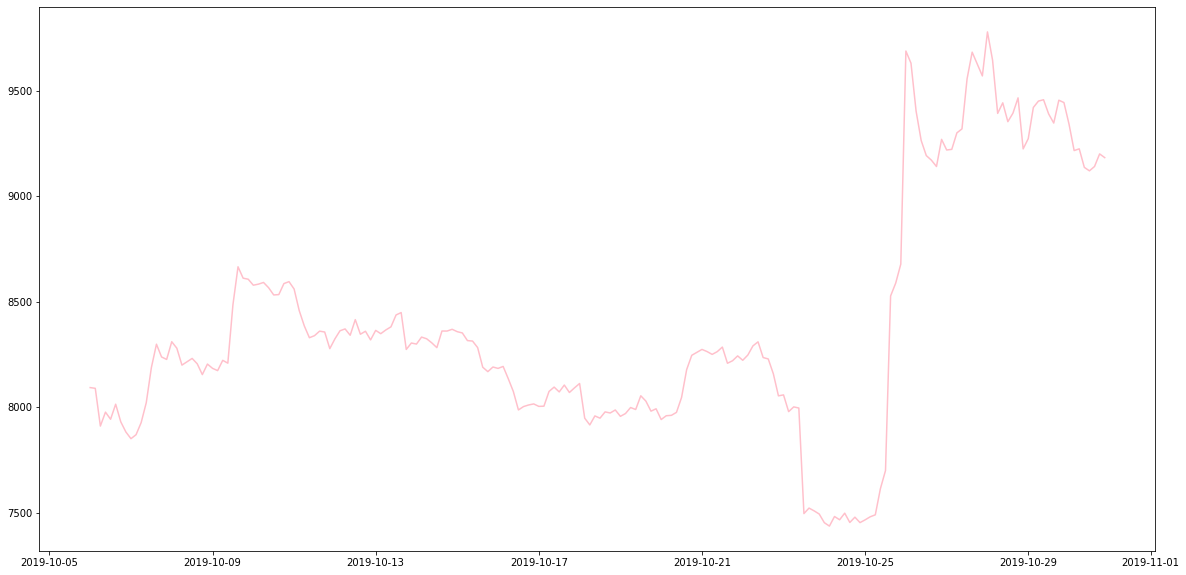

In [83]:
plt.figure(figsize=(20,10))
plt.plot(pd_result.index[:200], pd_result['Close'][:200], color='pink')

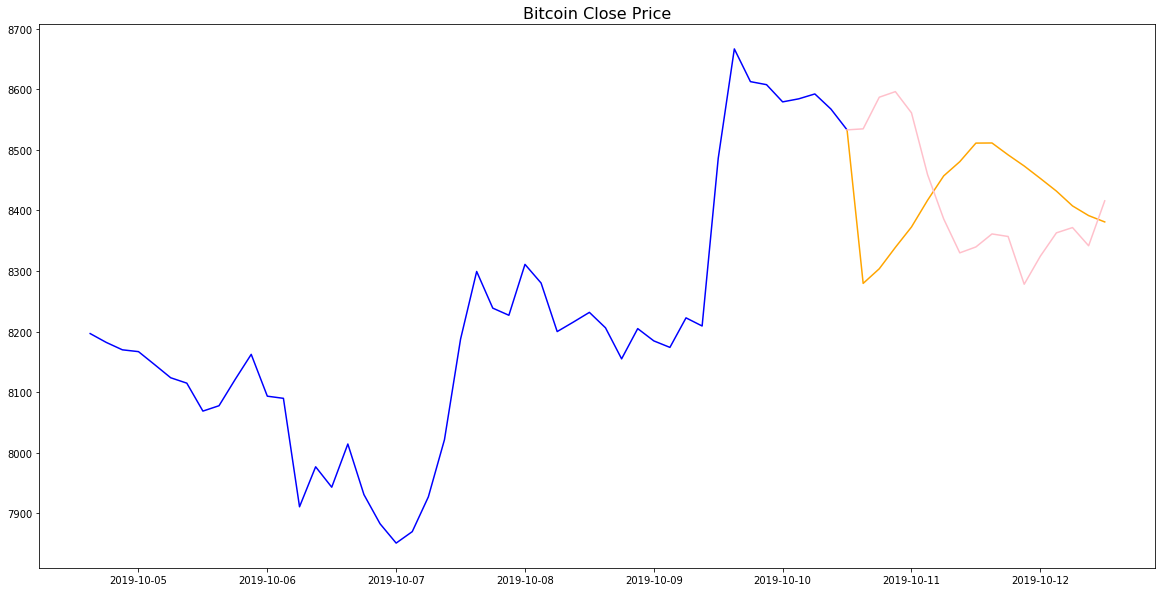

In [84]:
# Plot data.

plt.figure(figsize=(20,10))
plt.plot(pd_btc.index[-48:], close_data[-48:], color = 'blue')
plt.plot(forecast_dates, forecast, color = 'orange')
plt.plot(pd_result.index[36:53], pd_result['Close'][36:53], color='pink')
plt.title(label = 'Bitcoin Close Price', fontsize=16)
plt.show();

In [85]:
mse = mean_squared_error(forecast, pd_result['Close'][36:53])
print ('mse = ' + str(mse))
mae = mean_absolute_error(forecast, pd_result['Close'][36:53])
print ('mae = ' + str(mae))

mse = 24141.496804488135
mae = 130.34285519161742


In [86]:
forecast

array([8532.9       , 8279.61230469, 8303.74609375, 8339.01953125,
       8372.65527344, 8416.81152344, 8456.94921875, 8480.45019531,
       8511.07714844, 8511.28027344, 8491.68261719, 8473.30175781,
       8452.83300781, 8431.89648438, 8407.453125  , 8391.4765625 ,
       8381.02539062])

In [87]:
pd_result['Close'][36:53]

Date_Time
2019-10-10 12:00:00    8532.900000
2019-10-10 15:00:00    8534.600000
2019-10-10 18:00:00    8586.800000
2019-10-10 21:00:00    8596.000000
2019-10-11 00:00:00    8561.024615
2019-10-11 03:00:00    8459.000000
2019-10-11 06:00:00    8386.000000
2019-10-11 09:00:00    8330.000000
2019-10-11 12:00:00    8339.726350
2019-10-11 15:00:00    8361.200000
2019-10-11 18:00:00    8357.000000
2019-10-11 21:00:00    8278.200000
2019-10-12 00:00:00    8324.400000
2019-10-12 03:00:00    8363.000000
2019-10-12 06:00:00    8371.700000
2019-10-12 09:00:00    8341.700000
2019-10-12 12:00:00    8415.800000
Name: Close, dtype: float64

Auto_ARIMA

In [88]:
data = pd.DataFrame(pd_btc['Close'])
data.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 03:00:00',
               '2017-01-01 06:00:00', '2017-01-01 09:00:00',
               '2017-01-01 12:00:00', '2017-01-01 15:00:00',
               '2017-01-01 18:00:00', '2017-01-01 21:00:00',
               '2017-01-02 00:00:00', '2017-01-02 03:00:00',
               ...
               '2019-10-09 09:00:00', '2019-10-09 12:00:00',
               '2019-10-09 15:00:00', '2019-10-09 18:00:00',
               '2019-10-09 21:00:00', '2019-10-10 00:00:00',
               '2019-10-10 03:00:00', '2019-10-10 06:00:00',
               '2019-10-10 09:00:00', '2019-10-10 12:00:00'],
              dtype='datetime64[ns]', name='Date_Time', length=8101, freq=None)

In [89]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True, 
                           suppress_warnings=True, )

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=102994.257, BIC=103029.247, Fit time=67.068 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=108339.846, BIC=108353.842, Fit time=0.671 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=105919.247, BIC=105947.239, Fit time=24.184 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=102953.647, BIC=102981.640, Fit time=31.354 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=108337.857, BIC=108344.855, Fit time=0.317 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=108302.890, BIC=108330.883, Fit time=7.096 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=102992.017, BIC=103034.006, Fit time=124.536 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 

In [90]:
train_arima, test_arima = train_test_split(data, test_size=0.2, shuffle=False)
print(data.shape)
print(train_arima.shape)
print(test_arima.shape)

(8101, 1)
(6481, 1)
(1621, 1)


In [91]:
stepwise_model.fit(train_arima)

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [0]:
future_forecast = stepwise_model.predict(n_periods=1621)

In [95]:
future_forecast = pd.DataFrame(future_forecast,index = test_arima.index,columns=['Prediction'])
future_forecast

Prediction
Date_Time                       
2019-03-22 00:00:00  4046.664051
2019-03-22 03:00:00  4044.775679
2019-03-22 06:00:00  4041.986544
2019-03-22 09:00:00  4033.354276
2019-03-22 12:00:00  4022.207779
...                          ...
2019-10-10 00:00:00  -914.591871
2019-10-10 03:00:00  -913.295972
2019-10-10 06:00:00  -912.635318
2019-10-10 09:00:00  -916.986486
2019-10-10 12:00:00  -920.469245

[1621 rows x 1 columns]

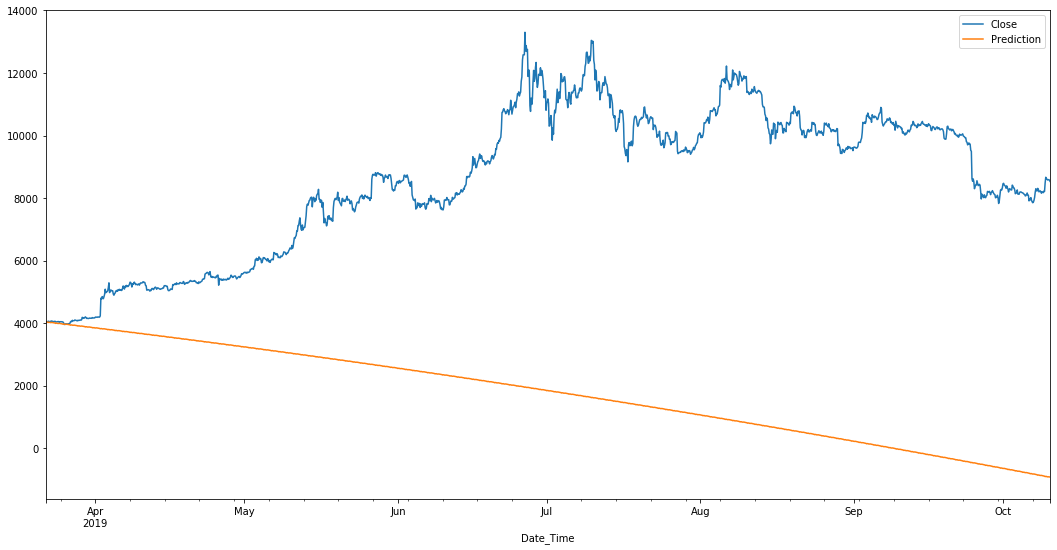

In [96]:
pd.concat([test_arima,future_forecast],axis=1).plot(figsize=(18,9))

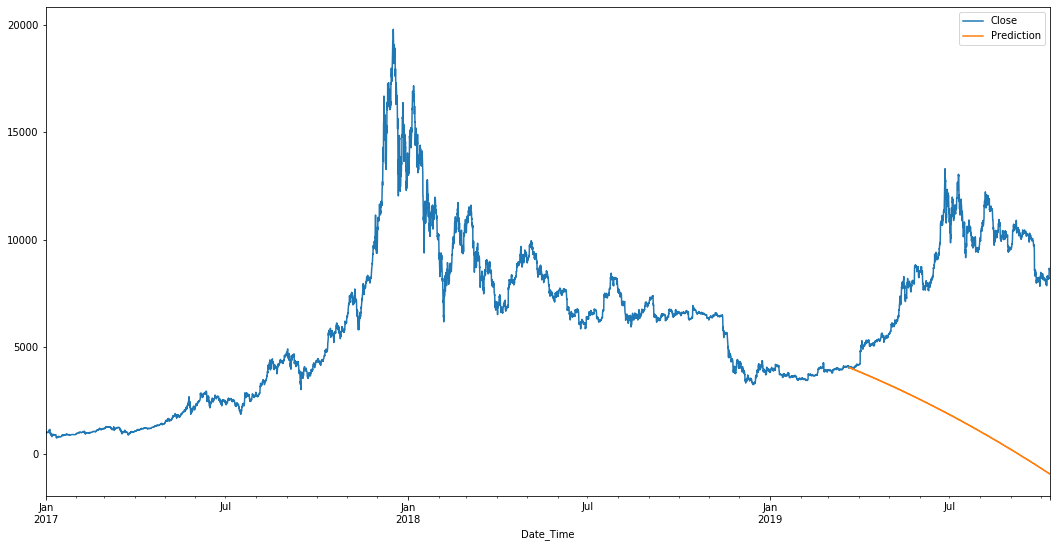

In [97]:
pd.concat([data,future_forecast],axis=1).plot(figsize=(18,9))

Linear Regression()


In [0]:
features = [i for i in pd_btc.columns if i != 'Close']
target = ['Close']

In [0]:
X = pd_btc[features]
y = pd_btc[target]

In [100]:
X.dtypes

Open         float64
High         float64
Low          float64
Volume       float64
High_Low     float64
High_Open    float64
Low_Open     float64
TR           float64
dtype: object

In [101]:
lr_train, lr_test = train_test_split(X, test_size=0.2, shuffle=False)
print(X.shape)
print(lr_train.shape)
print(lr_test.shape)

(8101, 8)
(6481, 8)
(1621, 8)


In [102]:
y_lr_train, y_lr_test = train_test_split(y, test_size=0.2, shuffle=False)
print(y.shape)
print(y_lr_train.shape)
print(y_lr_test.shape)

(8101, 1)
(6481, 1)
(1621, 1)


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
clf = LinearRegression()
clf.fit(lr_train, y_lr_train)
predicted = (clf.predict(lr_test))

In [105]:
predicted = pd.DataFrame(predicted,index = y_lr_test.index,columns=['Prediction'])
predicted

Prediction
Date_Time                       
2019-03-22 00:00:00  4047.778837
2019-03-22 03:00:00  4043.682485
2019-03-22 06:00:00  4041.728994
2019-03-22 09:00:00  4046.202909
2019-03-22 12:00:00  4062.836767
...                          ...
2019-10-10 00:00:00  8586.598135
2019-10-10 03:00:00  8595.585378
2019-10-10 06:00:00  8647.092947
2019-10-10 09:00:00  8540.488485
2019-10-10 12:00:00  8498.410055

[1621 rows x 1 columns]

In [106]:
y_lr_test

Close
Date_Time                       
2019-03-22 00:00:00  4049.300000
2019-03-22 03:00:00  4043.200000
2019-03-22 06:00:00  4046.900000
2019-03-22 09:00:00  4047.800000
2019-03-22 12:00:00  4060.300000
...                          ...
2019-10-10 00:00:00  8579.100000
2019-10-10 03:00:00  8584.127009
2019-10-10 06:00:00  8592.192830
2019-10-10 09:00:00  8567.200000
2019-10-10 12:00:00  8532.900000

[1621 rows x 1 columns]

In [107]:
trace1 = go.Scatter(
    x = y_lr_test.index,
    y = y_lr_test['Close'],
    mode = 'lines',
    name = 'Close'
)
trace2 = go.Scatter(
    x = predicted.index,
    y = predicted['Prediction'],
    mode = 'lines',
    name = 'Predicted',
)
layout = go.Layout(
    title = 'Actual vs Predicted',
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)

fig1 = go.Figure(data=[trace1, trace2], layout=layout)
fig1.show()

In [108]:
mse = mean_squared_error(predicted, y_lr_test)
print ('mse = ' + str(mse))
mae = mean_absolute_error(predicted, y_lr_test)
print ('mae = ' + str(mae))

mse = 2974.376749698727
mae = 33.935386875477256
